plotting with seaborn
only use under analysis environment due to package incompatibilities with default environment

In [6]:
import os
import numpy as np
import seaborn as sns
import pandas as pd

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator

# use seaborn for easier logrithmic color scale

In [2]:
def find_mousename(text):
    #finds name of mouse that follows the typical LSENS pattern: two letters followed by 3 numbers, ie AL000
    a= re.search('[a-zA-Z]{2}[0-9]{2,3}', text)
    return a[0]

def prep_df(df):
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    
    new= read_file.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df(folder,list_of_fname,inner=False):
    # combine multiple data frames, keeping only mouse name, region id and amount of um
    # by default, returns all of the regions that at least one brain that projects to it
    # if inner=True, then only return regions that overlaps in all brains
    
    #initialize a dataframe which will later be removed
    full_name_initial=os.path.join(folder, list_of_fname[0])
    full_df=prep_df(full_name_initial)
    
    if inner==True:
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1, join='inner')

    else: 
        for i in (list_of_fname):
            new_df=prep_df(os.path.join(folder, i))
            full_df=full_df=pd.concat([full_df, new_df],axis=1)

    full_df=full_df.T.iloc[1:]
    return full_df


def prep_df_specific(df,region_id=''):
    '''Look for regions belong to one of the group by specifying region_id = : 
    343 brainstem
    567 cerebrum
    leave empty for everything else
    ie prep_df_specific(path_to_df) gives regions not belonging to brainstem or cerebrum
    prep_df_specific(path_to_df, region_id =343) gives regions belonging to brainstem only
    '''
    
    # prepares df so that we only keep the id and total count
    # input is the full path and name of the .csv file
    read_file= pd.read_excel(df)
    
    #new= read_file.set_index('id').sort_values(by='graph_order').T
    #This lines sorts the region ids according to its graph order, such that related regions are ordered together 
    # ie, barrel field layers are grouped together
    # Note that this order would be disrupted when you have to later concatenate dfs with different columns...so need to rearrange later
    
    if region_id:
        specific_df=read_file.loc[read_file['structure_id_path'].str.contains(f'/{region_id}/', case=False)]
    else:
        searchfor = ['/343/','/567/']
        specific_df= read_file.loc[~read_file['structure_id_path'].str.contains('|'.join(searchfor), case=False)]            
    
    new= specific_df.set_index('acronym').T
    new_series=new.loc['counts']

    full_df= new_series.to_frame()
    full_df.rename(columns={'counts': find_mousename(df)}, inplace=1)
    return full_df

def combine_df_specific(folder,list_of_fname,region_id=''):
    
    '''    # combine multiple data frames, keeping only mouse name, region id and amount of voxels
    by default, returns all of the regions that at least one brain that projects to it
    region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''

    #initialize a list for data frames to combine
    df_list = []
    for i in parent_axons:
        this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id).T
        df_list.append(this_df)
    full_df = pd.concat(df_list)

    return full_df

# def combine_df_specific_new(folder,list_of_fname,region_id='', inner=False):
    
#     ''' !! Use this one becase combine_df_specific does not work in some cases which I havn't figured out why... 
#     combine multiple data frames, keeping only mouse name, region id and amount of voxels
#     by default, returns all of the regions that at least one brain that projects to it
#     region_id specifies to look for brain regions only belonging to brainstem(343), cerebrum(567) or all others('')'''
    
#     full_df=pd.DataFrame(columns=['acronym'])
#     for i in list_of_fname:
#         this_df = prep_df_specific(os.path.join(folder, i),region_id=region_id)
#         full_df=pd.merge(full_df,this_df,on='acronym', how='outer')
#     return full_df.set_index('acronym')

In [44]:
#find all relevant files
folder= r'D:\viral_results\s1'
outdir = r'D:\viral_results\s1_results'

files= [ i for i  in os.listdir(folder) if 'with_counts' in i]


In [45]:
side='right'
parent_axons= [ i for i  in os.listdir(folder) if f'axon_{side}' in i]
#change side to right and Rparent for the other hemisphere!

In [35]:
#parent_axons

In [46]:
axonal_df= combine_df(folder, parent_axons)
axonal_df=axonal_df.T


In [47]:
axonal_df

,AL207,AL209,AL211,AL213,AL215,AL254,AL255,AL257,AL273,AL274,AL285,AL290,AL291,AL292,AL293
acronym,,,,,,,,,,,,,,,
ll,5468,142,423,NaN,895,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sctv,4,68,420,NaN,997,NaN,NaN,NaN,1087,NaN,NaN,NaN,NaN,NaN,NaN
SCiw,276,552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EW,255,14,209,NaN,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PR,99,1141,147,NaN,NaN,NaN,NaN,NaN,NaN,198,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IO,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114,NaN,NaN,NaN,NaN,NaN,NaN
mtt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122,NaN,NaN,NaN,NaN,NaN


In [48]:

column_order= ['AL254', 'AL255', 'AL257','AL290','AL291','AL292','AL293','AL213','AL211','AL215','AL207', 'AL209','AL273','AL274','AL285']
# for verified s1 injections as of october 12 .2022
final=axonal_df[column_order]
df=final.fillna(1)

In [49]:
y=final.index.to_list()
test_order=[]

atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

for i in y:
    name=atlas_labels.query(f"acronym== '{i}'").parent_structure_id.values[0]
    test_order.append(name)

# get all the acronyms involved and their parent structure id

In [50]:
sort_acronym_df= pd.DataFrame({'acronyms':y, 'parent_structure_id': test_order})
sort_acronym_df.sort_values('parent_structure_id', inplace=True)
# sort the aconnyms based on parent structure id

In [51]:
final_df= df.reindex(sort_acronym_df.acronyms.to_list())
final_df

,AL254,AL255,AL257,AL290,AL291,AL292,AL293,AL213,AL211,AL215,AL207,AL209,AL273,AL274,AL285
acronym,,,,,,,,,,,,,,,
CB,1,1,1,1,1,1,1,1,1,1,426,41,1,1,1
lotd,1,1,1,1,1,1,1,10643,227,2439,1,1,1,1,1
lot,1,1,1,1,1,1,1,7725,1,3818,1,1,1,1,1
ACAd6b,1,1,1,1,1,1,1,434,235,367,1,1,1,1,1
ACAd2/3,132,1,1,1,1,1,374,38003,42857,34651,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VISpor5,1,1,1,1,1,1,1,20624,12398,39041,1,1,1,1,1
VISpor2/3,1,1,1,1,1,1,1,21780,25971,48510,1,1,1,1,1
VISpor4,1,1,1,1,1,1,1,1005,756,2267,1,1,1,1,1


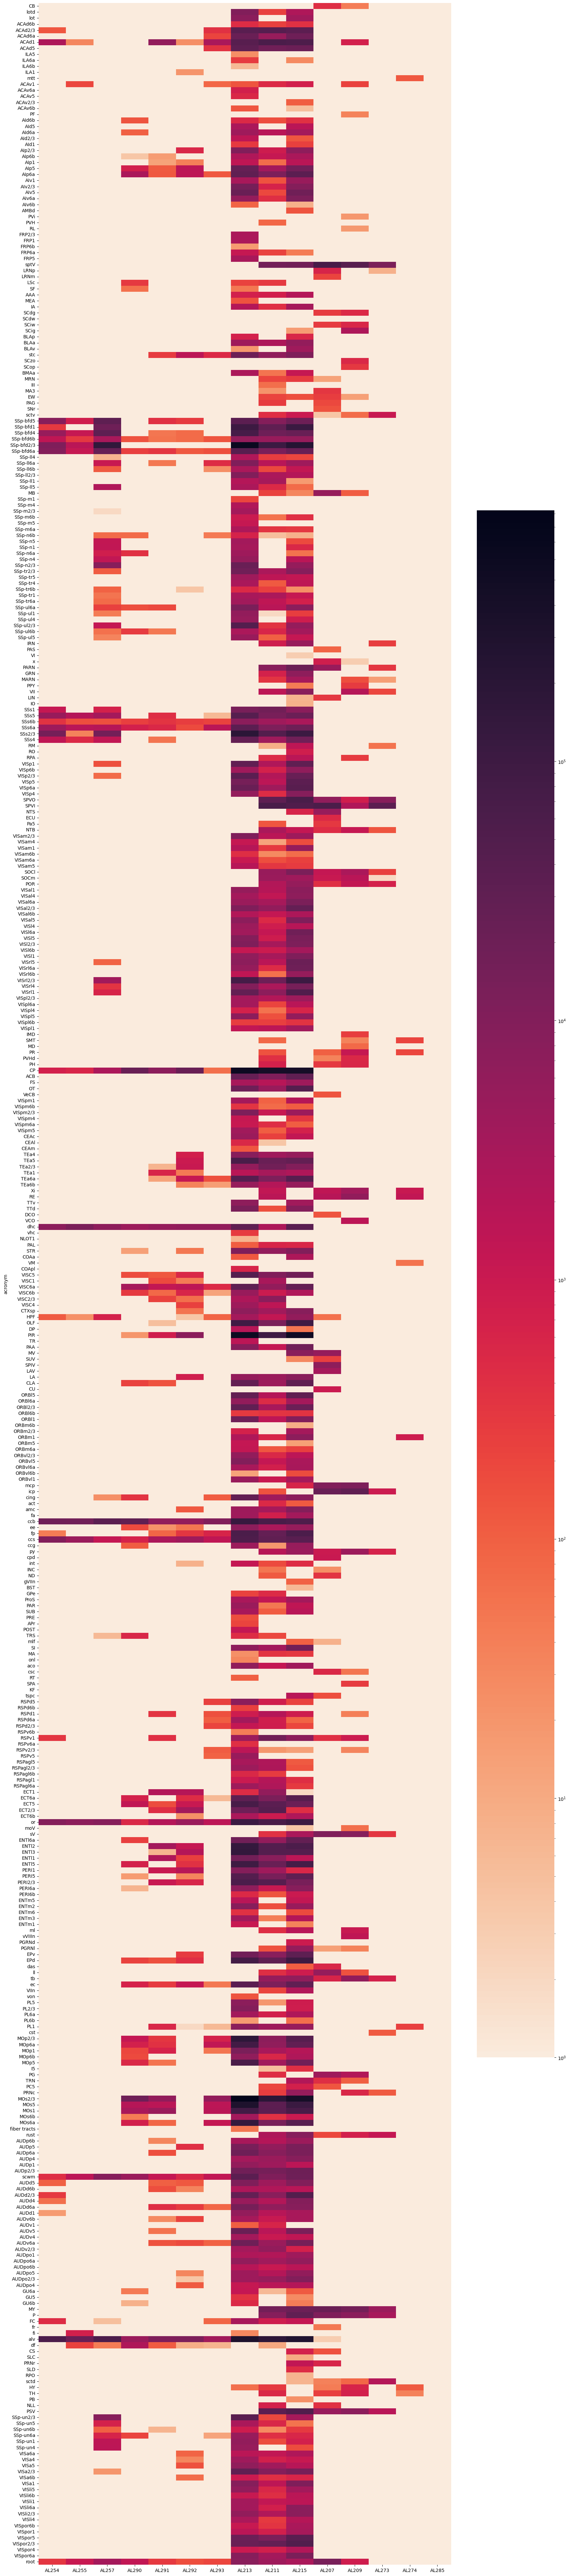

In [52]:
fig, ax = plt.subplots(figsize=(20,100))
sns.heatmap(final_df, norm=LogNorm(), cmap="rocket_r")

plt.savefig(f'{outdir}\{side}_heatmap_logscale.svg')
plt.show()